## Examples of ML algorithms and visualization

In [4]:
## packages import
%matplotlib inline
import os
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#plt.style.use('seaborn-bright')
#plt.style.available
import seaborn as sb

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(8, 6))

In [5]:
import random

def makeTerrainData(n_points=1000):
## make the toy dataset
    random.seed(42)
    grade = [random.random() for ii in range(0,n_points)]
    bumpy = [random.random() for ii in range(0,n_points)]
    error = [random.random() for ii in range(0,n_points)]
    y = [round(grade[ii]*bumpy[ii]+0.3+0.1*error[ii]) for ii in range(0,n_points)]
    for ii in range(0, len(y)):
        if grade[ii]>0.8 or bumpy[ii]>0.8:
            y[ii] = 1.0

## split into train/test sets
    X = [[gg, ss] for gg, ss in zip(grade, bumpy)]
    split = int(0.75*n_points)
    X_train = X[0:split]
    X_test  = X[split:]
    y_train = y[0:split]
    y_test  = y[split:]
    
    return X_train, y_train, X_test, y_test


def prettyPicture(clf, X_test, y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pcolormesh(xx, yy, Z, cmap=pl.cm.seismic)

    # Plot also the test points
    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    plt.scatter(grade_sig, bumpy_sig, color = "b", label="fast")
    plt.scatter(grade_bkg, bumpy_bkg, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")

NB Accuracy: 0.884


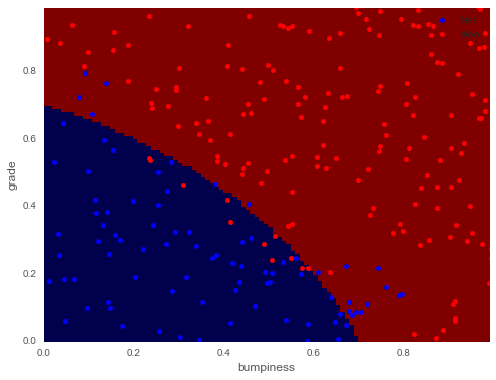

In [7]:
from sklearn.naive_bayes import GaussianNB

features_train, labels_train, features_test, labels_test = makeTerrainData()
clf = GaussianNB()
clf.fit(features_train, labels_train)
print "NB Accuracy:", clf.score(features_test, labels_test)
prettyPicture(clf, features_test, labels_test)

SVM Accuracy: 0.948


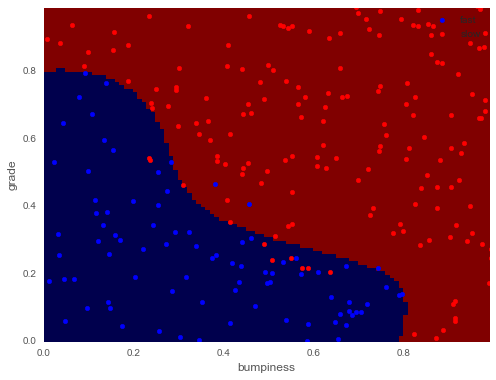

In [8]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf", C=1e4, gamma=1)
clf.fit(features_train, labels_train)
print "SVM Accuracy:", clf.score(features_test, labels_test)
prettyPicture(clf, features_test, labels_test)

kNN(k=7) Accuracy: 0.936


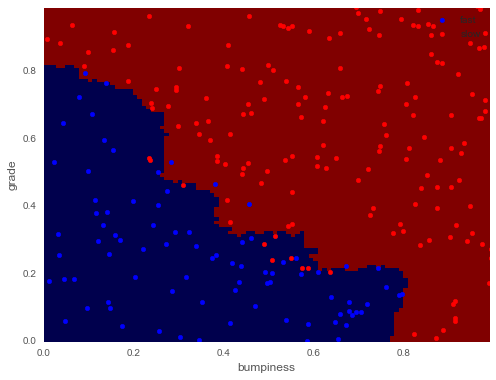

In [11]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(features_train, labels_train)
print "kNN(k=7) Accuracy:", clf.score(features_test, labels_test)
prettyPicture(clf, features_test, labels_test)

DT Accuracy: 0.92


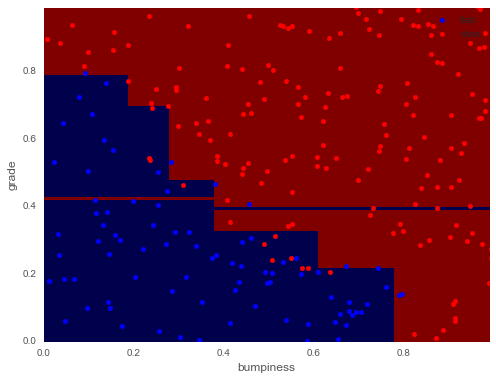

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(features_train, labels_train)
print "DT Accuracy:", clf.score(features_test, labels_test)
prettyPicture(clf, features_test, labels_test)

RF Accuracy: 0.92


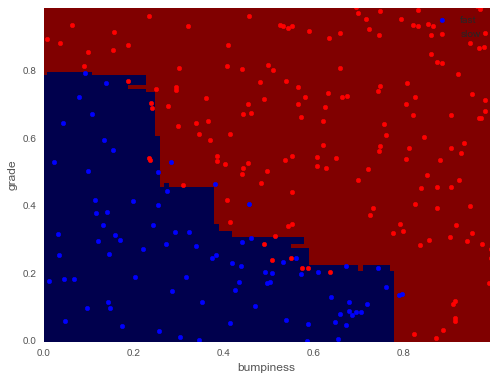

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=42)
clf.fit(features_train, labels_train)
print "RF Accuracy:", clf.score(features_test, labels_test)
prettyPicture(clf, features_test, labels_test)

In [18]:
import sys
import pickle
sys.path.append("./tools/")
from feature_format import featureFormat, targetFeatureSplit
dictionary = pickle.load( open("./final_project/final_project_dataset_modified.pkl", "r") )

features_list = ["bonus", "salary"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

from sklearn.cross_validation import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(feature_train, target_train)

print "Slope:", reg.coef_
print "Intercept:", reg.intercept_
print "## status on train dataset ##"
print "r-squared score:", reg.score(feature_train, target_train)
print "## status on test dataset ##"
print "r-squared score:", reg.score(feature_test, target_test)
print "The regressive equation:\n    Bonus =", reg.coef_[0], "Salary +", reg.intercept_

Slope: [ 5.44814029]
Intercept: -102360.543294
## status on train dataset ##
r-squared score: 0.0455091926995
## status on test dataset ##
r-squared score: -1.48499241737
The regressive equation:
    Bonus = 5.44814028881 Salary + -102360.543294


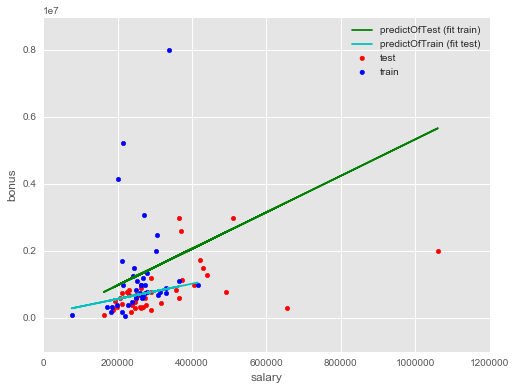

In [20]:
plt.scatter( feature_test, target_test, color="r", label="test" ) 
plt.scatter( feature_train, target_train, color="b", label="train" ) 
plt.plot( feature_test, reg.predict(feature_test), color="g", label="predictOfTest (fit train)")

# interchange training set and test set
reg.fit(feature_test, target_test)
plt.plot(feature_train, reg.predict(feature_train), color="c", label="predictOfTrain (fit test)")
plt.xlabel(features_list[1])
plt.ylabel(features_list[0])
plt.legend()

In [ ]:
## Cleaning outliers
def outlierCleaner(predictions, ages, net_worths):
    """ Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual net worth).

        Return a list of tuples named cleaned_data where 
        each tuple is of the form (age, net_worth, error).
    """
    resid_err = abs(predictions - net_worths)

    resid_err = resid_err.T[0]
    ages = ages.T[0]
    net_worths = net_worths.T[0]
    for i in range( int(round(0.1 * len(ages))) ):
        which = np.where(resid_err == max(resid_err))[0][0]
        resid_err = np.delete(resid_err, which)
        ages = np.delete(ages, which)
        net_worths = np.delete(net_worths, which)
    
    cleaned_data = zip(ages, net_worths, resid_err)
    
    return cleaned_data


ages = pickle.load( open("./outliers/practice_outliers_ages.pkl", "r") )
net_worths = pickle.load( open("./outliers/practice_outliers_net_worths.pkl", "r") )
